<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>

# Machine Learning Foundation

## Course 3, Part e: Bagging DEMO

Estimated time needed: **45** minutes

## Objectives

After completing this demo you will be able to:

*   Understand what Bagging is
*   Recognize that Random Forests is an implementation of bagging and its abilities
*   Describe the advantages of Random Forests over simply adding extra Decision Trees


<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="https://#Setup">Part 1: Setup</a></li>
        <li><a href="https://#TargPreproc">Part 2: Examining the Target and Preprocessing</a></li>
        <li><a href="https://#OOB">Part 3: Random Forest and Out-of-bag Error</a></li>
        <li><a href="https://#ExtraTrees">Part 4: Extra Trees</a></li>
        <li><a href="https://#results">Part 5: Gathering Results</a></li>
        <li><a href="https://#examineRes">Part 6: Examining Results</a></li>
</div>
<br>
<hr>


## Introduction

We will be using the customer churn data from the telecom industry that we used in the KNN Lab. Since we preprocessed the data there, we will import the preprocessed data, which is in a file called: 'churndata_processed.csv'


In [4]:
import warnings

def warn(*args, **kwargs):
    pass

warnings.warn = warn


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h2 id = "Setup"> Part 1: Setup </h2>

*   The raw churndata has been setup as a variable 'churndata', and we have imported it above.
*   We will rely on the data preprocessing from the KNN lab, which is captured in the file 'churndata_processed.csv'
*   First, import that file and examine its contents.
*   Output summary statistics and check variable data types
*   Using Seaborn, plot a heatmap of variable correlations


In [6]:
data = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/churndata_processed.csv")

In [7]:
data.head()

,months,multiple,gb_mon,security,backup,protection,support,unlimited,contract,paperless,...,payment_Credit Card,payment_Mailed Check,internet_type_DSL,internet_type_Fiber Optic,internet_type_None,offer_Offer A,offer_Offer B,offer_Offer C,offer_Offer D,offer_Offer E
0,0.00,0,0.094118,0,0,1,0,0,0.0,1,...,0,0,1,0,0,0,0,0,0,0
1,0.00,1,0.200000,0,1,0,0,1,0.0,1,...,1,0,0,1,0,0,0,0,0,1
2,0.25,1,0.611765,0,0,0,0,1,0.0,1,...,0,0,0,1,0,0,0,0,1,0
3,0.25,0,0.141176,0,1,1,0,1,0.0,1,...,0,0,0,1,0,0,0,1,0,0
4,0.50,1,0.164706,0,0,0,0,1,0.0,1,...,0,0,0,1,0,0,0,1,0,0


In [8]:
data.dtypes

months                       float64
multiple                       int64
gb_mon                       float64
security                       int64
backup                         int64
protection                     int64
support                        int64
unlimited                      int64
contract                     float64
paperless                      int64
monthly                      float64
satisfaction                 float64
churn_value                    int64
payment_Credit Card            int64
payment_Mailed Check           int64
internet_type_DSL              int64
internet_type_Fiber Optic      int64
internet_type_None             int64
offer_Offer A                  int64
offer_Offer B                  int64
offer_Offer C                  int64
offer_Offer D                  int64
offer_Offer E                  int64
dtype: object

Define Y_COLUMN and FEATURE_COLUMNS.

In [9]:
Y_COLUMN = 'churn_value'
FEATURE_COLUMNS = [colname for colname in data.columns if colname != Y_COLUMN]

In [10]:
data[Y_COLUMN].unique()

array([1, 0])

<Axes: >

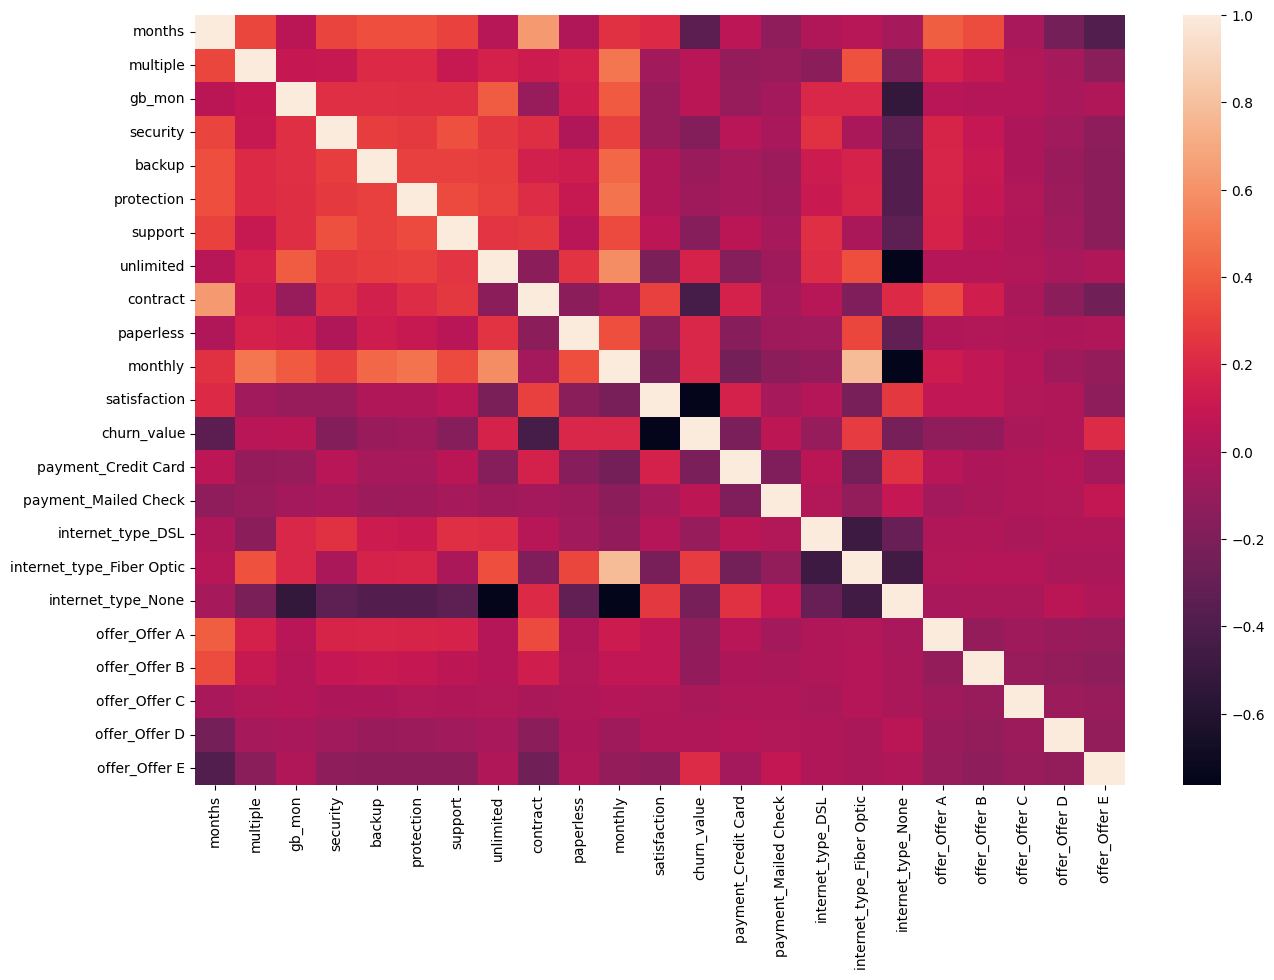

In [11]:
fix, ax = plt.subplots(figsize=(15,10))
sns.heatmap(data.corr())

<h2 id="TargPreproc">Part 2: Examining the Target and Preprocessing</h2>

In this exercise, we will proceed as follows:

*   Examine distribution of the predicted variable (`churn_value`).
*   Split the data into train and test sets. Decide if a stratified split should be used or not based on the distribution.
*   Examine the distribution of the predictor variable in the train and test data.


In [12]:
data[Y_COLUMN].value_counts(normalize=True)

churn_value
0    0.73463
1    0.26537
Name: proportion, dtype: float64

Given the skew in the predictor variable, let's split the data with the *churned* values being stratified to ensure that the test and train sets have similar distributions.


In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

In [14]:
strat_shuff_split = StratifiedShuffleSplit(n_splits=1,
                                           test_size=1500,
                                           random_state=42)
train_idx, test_idx = next(strat_shuff_split.split(data[FEATURE_COLUMNS], data[Y_COLUMN]))
print(f"train_idx shape: {train_idx.shape}, test_idx shape: {test_idx.shape}")

train_idx shape: (5543,), test_idx shape: (1500,)


In [15]:
X_train, y_train = data.loc[train_idx, FEATURE_COLUMNS], data.loc[train_idx, Y_COLUMN]
X_test, y_test = data.loc[test_idx, FEATURE_COLUMNS], data.loc[test_idx, Y_COLUMN]

In [16]:
y_train.value_counts(normalize=True)

churn_value
0    0.73462
1    0.26538
Name: proportion, dtype: float64

In [17]:
y_test.value_counts(normalize=True)

churn_value
0    0.734667
1    0.265333
Name: proportion, dtype: float64

<h2 id ="OOB">Part 3: Random Forest and Out-of-bag(oob) Error</h2>

In this exercise, we will:

*   Fit random forest models with a range of tree numbers and evaluate the out-of-bag error for each of these models.
*   Plot the resulting oob errors as a function of the number of trees.

*Note:* since the only thing changing is the number of trees, the `warm_start` flag can be used so that the model just adds more trees to the existing model each time. Use the `set_params` method to update the number of trees.


In [18]:
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [19]:
from sklearn.ensemble import RandomForestClassifier

random_forest_classifier = RandomForestClassifier(
    oob_score=True,
    random_state=42,
    warm_start=True,
    n_jobs=-1
)

In [20]:
def get_oob_error(model,
                  n_trees,
                  X_train,
                  y_train) -> float:
    """Calculates to OOB Error for Random Forest

    Args:
        model (_type_): _description_
        n_trees (_type_): _description_
        X_train (_type_): _description_
        y_train (_type_): _description_

    Returns:
        float: _description_
    """
    model.set_params(n_estimators=n_trees)
    model.fit(X_train, y_train)
    return 1.0 - model.oob_score_

n_trees = [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]

In [21]:
oob_scores = [get_oob_error(random_forest_classifier,
                            n_tree,
                            X_train,
                            y_train) for n_tree in n_trees]

In [22]:
rf_oob_df = pd.DataFrame(oob_scores, columns=['rf_oob_scores'], index=n_trees)
rf_oob_df

,rf_oob_scores
15,0.055566
20,0.052138
30,0.049973
40,0.048890
50,0.049071
100,0.047447
150,0.046726
200,0.047447
300,0.047988
400,0.047808


[Text(0, 0.5, 'out of bag error')]

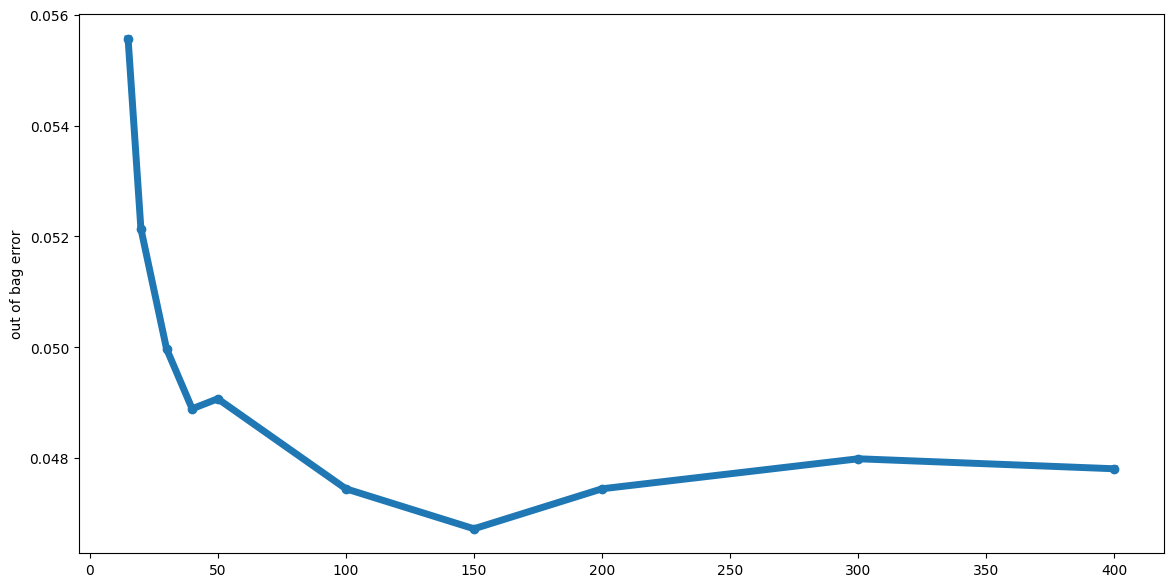

In [23]:
ax = rf_oob_df.plot(legend=False,
                    marker='o',
                    figsize=(14, 7),
                    linewidth=5)
ax.set(ylabel='out of bag error')

<h2 id = "ExtraTrees">Part 4: Extra Trees</h2>

Our exercise:

*   Repeat question 3 using extra randomized trees (`ExtraTreesClassifier`). Note that the `bootstrap` parameter will have to be set to `True` for this model.
*   Compare the out-of-bag errors for the two different types of models.


In [24]:
from sklearn.ensemble import ExtraTreesClassifier

extra_trees_classifier = ExtraTreesClassifier(
    oob_score=True,
    random_state=42,
    warm_start=True,
    bootstrap=True
)

In [25]:
extra_trees_oob_errors = [get_oob_error(extra_trees_classifier,
                                        tree_num,
                                        X_train,
                                        y_train)
                          for tree_num in n_trees]

In [26]:
et_oob_df = pd.DataFrame(extra_trees_oob_errors, columns=['et_oob_error'], index=n_trees)
et_oob_df

,et_oob_error
15,0.066570
20,0.063864
30,0.057550
40,0.053942
50,0.052318
100,0.051236
150,0.048890
200,0.048530
300,0.049612
400,0.048530


[Text(0, 0.5, 'out of bag error')]

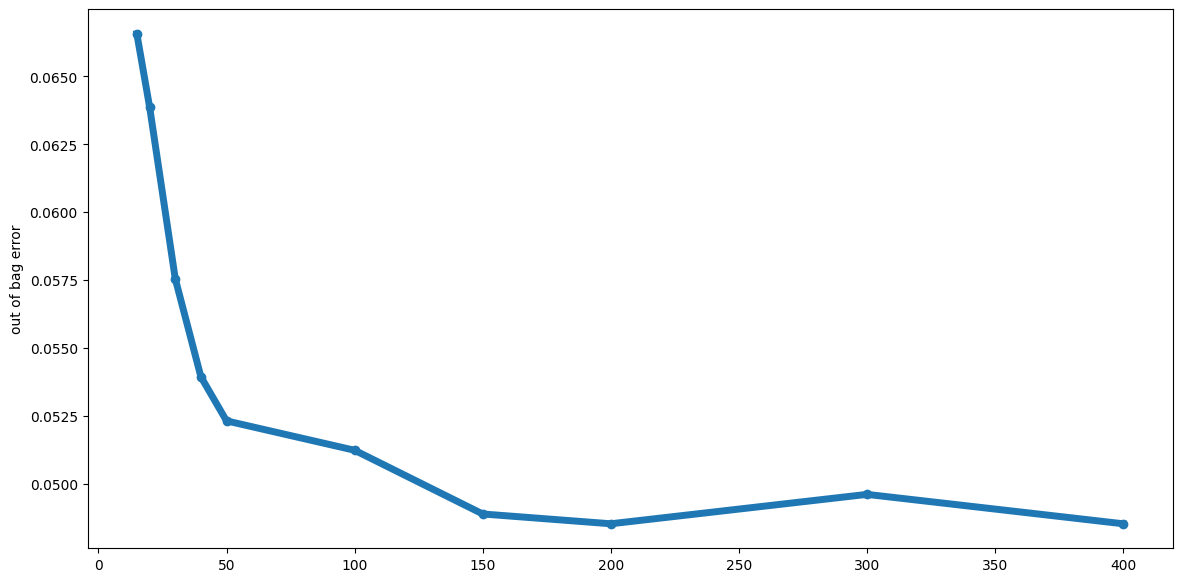

In [27]:
ax = et_oob_df.plot(legend=False,
                    marker='o',
                    figsize=(14, 7),
                    linewidth=5)
ax.set(ylabel='out of bag error')

In [28]:
test_df1 = pd.DataFrame([1, 2, 3], columns=['test 1'], index=[5, 10, 15])
test_df2 = pd.DataFrame([4, 5, 6], columns=['test 2'], index=[5, 10, 15])


In [29]:
joined_test_df = pd.concat([test_df1, test_df2], axis=1)
joined_test_df

,test 1,test 2
5,1,4
10,2,5
15,3,6


In [30]:
oob_scores = pd.concat([rf_oob_df, et_oob_df], axis=1)
oob_scores

,rf_oob_scores,et_oob_error
15,0.055566,0.066570
20,0.052138,0.063864
30,0.049973,0.057550
40,0.048890,0.053942
50,0.049071,0.052318
100,0.047447,0.051236
150,0.046726,0.048890
200,0.047447,0.048530
300,0.047988,0.049612
400,0.047808,0.048530


[Text(0, 0.5, 'out of bag errors combined')]

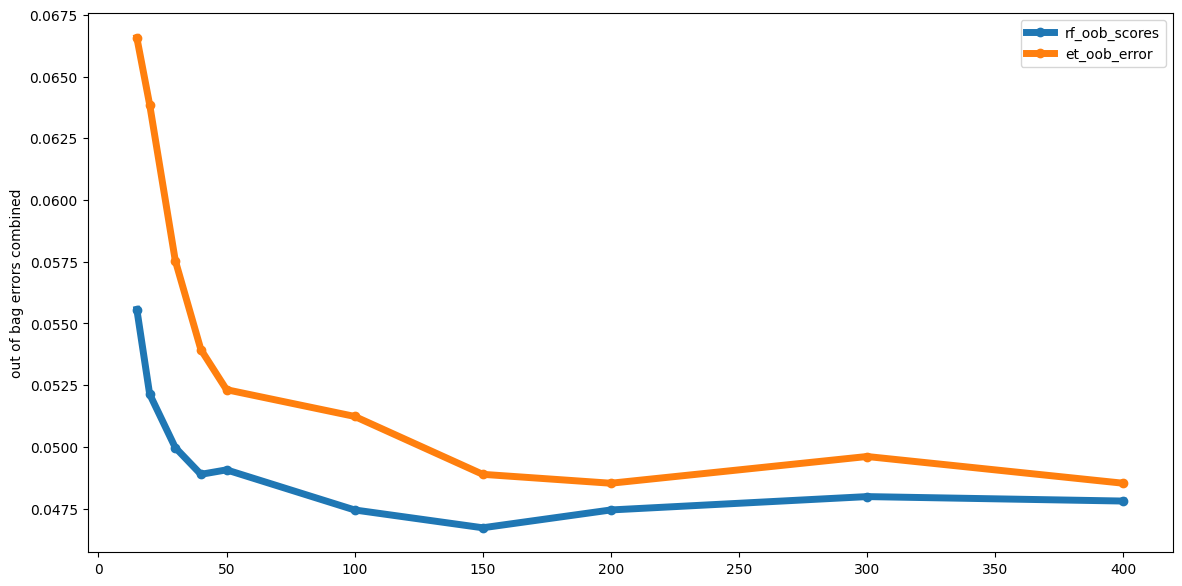

In [31]:
ax = oob_scores.plot(marker='o',
                     figsize=(14, 7),
                     linewidth=5)
ax.set(ylabel='out of bag errors combined')

<h2 id="results">Part 5: Gathering Results</h2>

Here, we will:

*   Select one of the models that performs well and calculate error metrics and a confusion matrix on the test data set.
*   Given the distribution of the predicted class, which metric is most important? Which could be deceiving?


In [32]:
model = random_forest_classifier.set_params(n_estimators=150)

In [33]:
y_pred = random_forest_classifier.predict(X_test)

In [34]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, \
                            f1_score, roc_auc_score

Unsurprisingly, recall is rather poor for the customers who churned (True) class since they are quite small. We are doing better than random guessing, though, as the accuracy is 0.94 (vs 0.85 for random guessing).


In [35]:
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1102
           1       0.94      0.83      0.88       398

    accuracy                           0.94      1500
   macro avg       0.94      0.90      0.92      1500
weighted avg       0.94      0.94      0.94      1500



In [36]:
score_df = pd.DataFrame({
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'auc': roc_auc_score(y_test, y_pred)
    },
    index=pd.Index([0]))
score_df

,accuracy,precision,recall,f1,auc
0,0.94,0.9375,0.829146,0.88,0.904591


<h2 id="examineRes">Part 6: Examining Results</h2>

The following exercises will help us examine results:

*   Print or visualize the confusion matrix.
*   Plot the ROC-AUC and precision-recall curves.
*   Plot the feature importances.


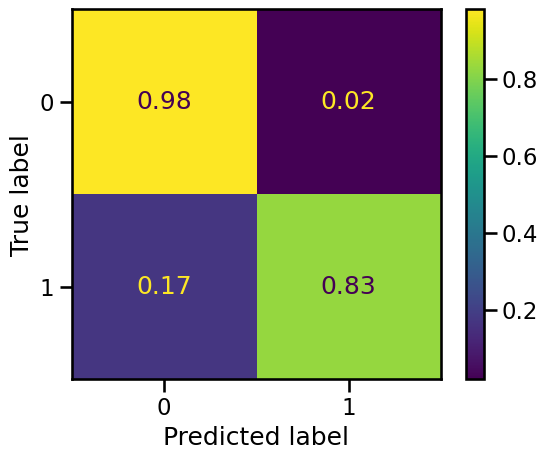

In [39]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

The ROC-AUC and precision-recall curves.

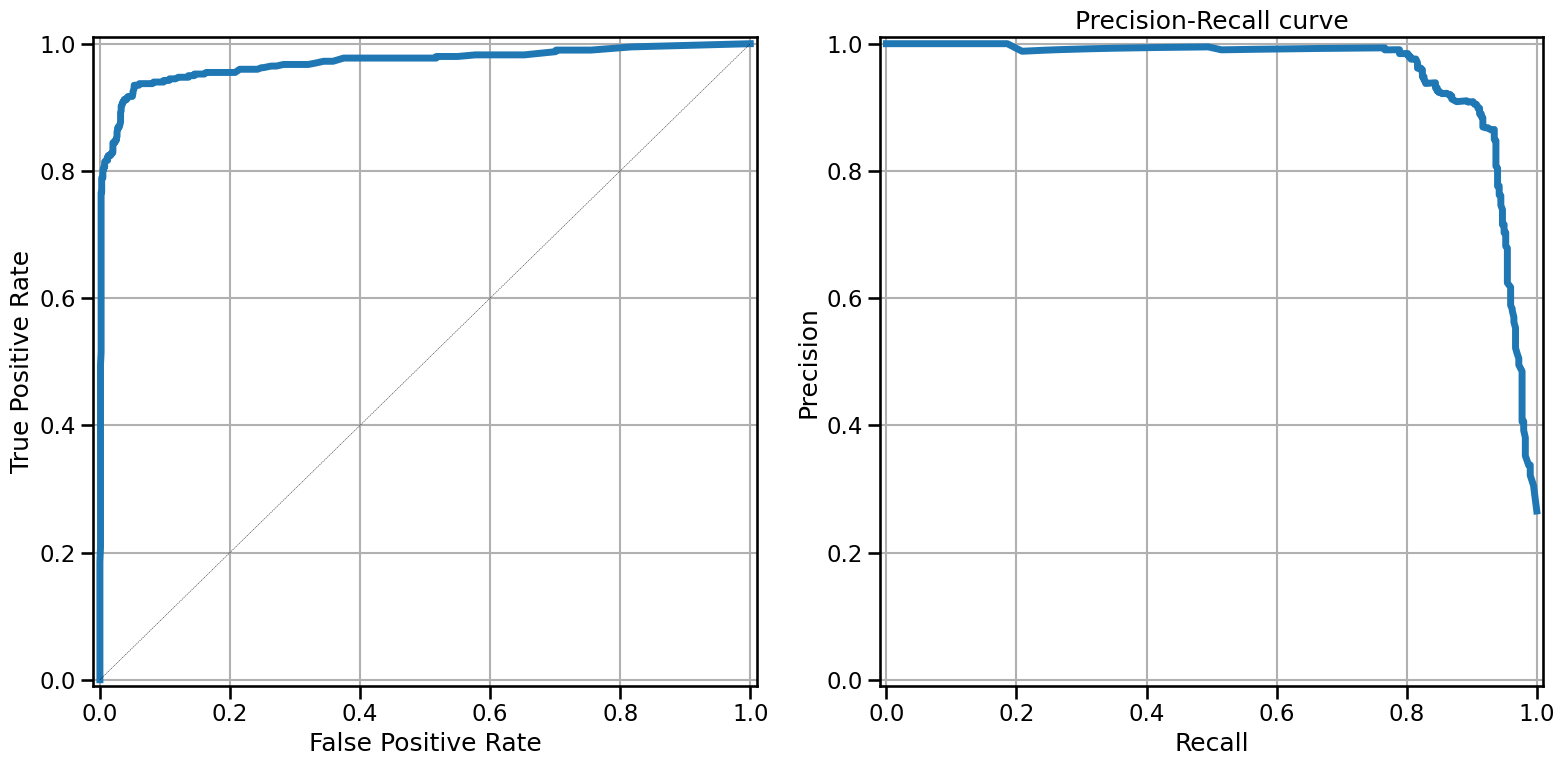

In [44]:
sns.set_context('talk')

fig, axlist = plt.subplots(ncols=2)
fig.set_size_inches(16, 8)

y_prob = model.predict_proba(X_test)

ax = axlist[0]

fqr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
ax.plot(fqr, tpr, linewidth=5)

ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-0.01, 1.01])
ax.grid(True)

ax = axlist[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision, linewidth=5)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()
